# Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab_Projects/제조데이터 모델링_ 공모전
!ls

/content/drive/MyDrive/Colab_Projects/제조데이터 모델링_ 공모전
 Datasets   사용자_정의_함수.ipynb		      Model
 Docs	   '제조기기의 불량과 원인 예측 모델.ipynb'


In [ ]:
!pip install import_ipynb

# Data Exploration

In [ ]:
from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from keras.models import load_model

import import_ipynb
from 사용자_정의_함수 import *

importing Jupyter notebook from 사용자_정의_함수.ipynb


### Data Preprocessing 

In [ ]:
# 원 데이터 셋의 문자열로 구성된 특성을 숫자로 인코딩이 필요한 열 지정
Pre_col = ['PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'PassOrFail']

# preprocessor() 는 정의 함수로서 경로의 데이터셋을 생성, Pre_col을 인코딩하고, target 의 열을 라벨, 입력값과 출력값으로 분리한다.
X, Y = preprocessor('./Datasets/경진대회용 사출성형기 데이터셋_labeled.csv', encoding_col = Pre_col, target= 'Reason')
X

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,1,2,2,1,9.59,4.47,16.920000,59.520000,653.409973,68.849998,647.98999,55.400002,30.700001,292.500000,141.800003,37.400002,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.500000
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,1,2,2,1,9.60,4.48,16.910000,59.580002,653.409973,68.839996,647.98999,55.299999,30.799999,292.500000,141.800003,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,0,2,2,1,9.60,4.48,16.910000,59.580002,653.409973,68.839996,647.98999,55.299999,30.799999,292.500000,141.800003,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,0,2,2,1,9.59,4.48,16.910000,59.560001,653.419983,68.839996,647.98999,55.299999,31.000000,292.500000,141.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,1,2,2,1,9.59,4.48,16.910000,59.560001,653.419983,68.839996,647.98999,55.299999,31.000000,292.500000,141.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,5fa112859c0189cc66dabe34,2020-11-03 08:17:36,2020-11-03 오전 12:00:00,6,0,2,2,1,9.60,4.48,16.620001,59.560001,653.429993,68.330002,647.98999,54.900002,30.700001,29.200001,142.100006,38.299999,59.900002,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,66.099998,21.000000,22.400000
7992,5fa112869c0189cc66dabe42,2020-11-03 08:18:37,2020-11-03 오전 12:00:00,7,1,2,2,1,9.60,4.48,16.650000,59.560001,653.429993,68.349998,647.98999,55.000000,30.700001,29.200001,142.100006,38.400002,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7993,5fa112879c0189cc66dabe50,2020-11-03 08:18:37,2020-11-03 오전 12:00:00,6,0,2,2,1,9.60,4.48,16.650000,59.560001,653.429993,68.349998,647.98999,55.000000,30.700001,29.200001,142.100006,38.400002,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7994,5fa112bb9c0189cc66dac22a,2020-11-03 08:19:35,2020-11-03 오전 12:00:00,6,0,2,2,1,9.60,4.48,16.629999,59.580002,653.429993,68.330002,647.98999,54.900002,30.700001,29.200001,142.100006,38.400002,59.900002,276.100006,275.799988,275.000000,271.299988,255.100006,230.199997,65.199997,21.000000,22.299999


In [ ]:
# 선택된 열은 데이터를 추측하는데 무의미한 특성이라고 생각하여 제외합니다.
Sel_col = ['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE']
X = X.drop(Sel_col, axis=1)
X

,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,24,1,2,2,1,9.59,4.47,16.920000,59.520000,653.409973,68.849998,647.98999,55.400002,30.700001,292.500000,141.800003,37.400002,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.500000
1,24,1,2,2,1,9.60,4.48,16.910000,59.580002,653.409973,68.839996,647.98999,55.299999,30.799999,292.500000,141.800003,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
2,23,0,2,2,1,9.60,4.48,16.910000,59.580002,653.409973,68.839996,647.98999,55.299999,30.799999,292.500000,141.800003,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
3,23,0,2,2,1,9.59,4.48,16.910000,59.560001,653.419983,68.839996,647.98999,55.299999,31.000000,292.500000,141.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
4,24,1,2,2,1,9.59,4.48,16.910000,59.560001,653.419983,68.839996,647.98999,55.299999,31.000000,292.500000,141.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,6,0,2,2,1,9.60,4.48,16.620001,59.560001,653.429993,68.330002,647.98999,54.900002,30.700001,29.200001,142.100006,38.299999,59.900002,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,66.099998,21.000000,22.400000
7992,7,1,2,2,1,9.60,4.48,16.650000,59.560001,653.429993,68.349998,647.98999,55.000000,30.700001,29.200001,142.100006,38.400002,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7993,6,0,2,2,1,9.60,4.48,16.650000,59.560001,653.429993,68.349998,647.98999,55.000000,30.700001,29.200001,142.100006,38.400002,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7994,6,0,2,2,1,9.60,4.48,16.629999,59.580002,653.429993,68.330002,647.98999,54.900002,30.700001,29.200001,142.100006,38.400002,59.900002,276.100006,275.799988,275.000000,271.299988,255.100006,230.199997,65.199997,21.000000,22.299999


In [ ]:
# 결과값의 분포 1: 가스, 2 : 미성형, 3 : 초기허용불량 코드.
class_rate = Y.value_counts().values.tolist()
class_rate

[7925, 35, 20, 16]

In [ ]:
total = sum(class_rate)
total

7996

<function matplotlib.pyplot.show>

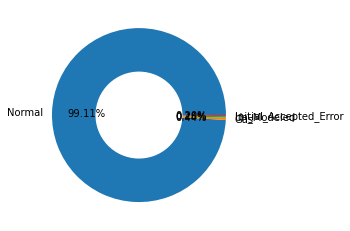

In [ ]:
plt.pie(class_rate, labels= ['Normal', 'Gas', 'Un_Modeled', 'Initial_Accepted_Error'], autopct= '%.2f%%', wedgeprops= {'width': 0.5, 'linewidth': 5})
plt.show

In [ ]:
# 훈련 셋 6 : 검증 셋 4 의 비율로 분할
x_train, x_valid, y_train, y_valid, scaler = Split_n_Scale(X.values, Y.values, valid_size = 0.4)

# Random Forest Classifier

### Implementation

In [ ]:
#RFC = RandomForestClassifier()
#RFC.fit(x_train, y_train)

### Result

In [ ]:
# 저장되었던 모델을 호출하여 재사용
# 해당 모델은 위의 선언으로 만들어진 모델
RFC = joblib.load('./Model/RFC.pkl')

In [ ]:
pred = RFC.predict(x_valid)
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3164
           1       0.75      0.71      0.73        21
           2       0.33      0.38      0.35         8
           3       1.00      1.00      1.00         6

    accuracy                           1.00      3199
   macro avg       0.77      0.77      0.77      3199
weighted avg       1.00      1.00      1.00      3199



In [ ]:
# 모델을 파일로 저장
# joblib.dump(RFC, './Model/RFC.pkl')

# Gradient Boosting Classification

### Implementation

In [ ]:
# 그래디언트 부스팅 분류기 호출
# GBC = GradientBoostingClassifier()

# 그래디언트 부스팅 모델의 훈련
# GBC.fit(x_train, y_train)

### Draft Result

In [ ]:
# 훈련된 초기 모델의 성적표 출력
# pred = GBC.predict(x_valid)
# print(classification_report(y_valid, pred))

### Fine Tuning

In [ ]:
# 정밀 최적화를 위한 조건 값
'''
params = {
    'n_estimators':[200, 250, 300, 350, 400],
    'learning_rate':[0.03, 0.035, 0.04, 0.045, 0.05],
    }

정밀 최적화 GridSearchCV 를 통한 최고 성적 모델을 탐색
grid_cv = GridSearchCV(GBC, param_grid = params, scoring= 'f1_macro', n_jobs=-1, cv = 2, verbose = 1)
grid_cv.fit(x_train, y_train)

정밀 최적화 된 모델의 조건 값 : 파라미터 확인
print('Parameter :',grid_cv.best_params_)

조건 값 : 최고 성적의 파라미터를 적용한 모델
GBC = grid_cv.best_estimator_
'''

"\nparams = {\n    'n_estimators':[200, 250, 300, 350, 400],\n    'learning_rate':[0.03, 0.035, 0.04, 0.045, 0.05],\n    }\n\n정밀 최적화 GridSearchCV 를 통한 최고 성적 모델을 탐색\ngrid_cv = GridSearchCV(GBC, param_grid = params, scoring= 'f1_macro', n_jobs=-1, cv = 2, verbose = 1)\ngrid_cv.fit(x_train, y_train)\n\n정밀 최적화 된 모델의 조건 값 : 파라미터 확인\nprint('Parameter :',grid_cv.best_params_)\n\n조건 값 : 최고 성적의 파라미터를 적용한 모델\nGBC = grid_cv.best_estimator_\n"

### Final Result

In [ ]:
GBC = joblib.load('./Model/GBC.pkl')

In [ ]:
# 최고 성적의 모델 평가
pred = GBC.predict(x_valid)
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3164
           1       0.83      0.90      0.86        21
           2       0.67      0.50      0.57         8
           3       1.00      1.00      1.00         6

    accuracy                           1.00      3199
   macro avg       0.87      0.85      0.86      3199
weighted avg       1.00      1.00      1.00      3199



In [ ]:
# 모델을 파일로 저장
# joblib.dump(GBC, './Model/GBC.pkl')

# Shallow Neural Network

### Training and Implemnetation

In [ ]:
weight_dict = {}
for idx, rate in enumerate(class_rate):
  weight_dict[idx] = (1/rate) * (total/ 4)

weight_dict

{0: 0.2522397476340694, 1: 57.114285714285714, 2: 99.95, 3: 124.9375}

In [ ]:
# 훈련 셋의 열은 특성의 개수 이므로 형태를 반환하는 함수를 통해 특성 개수를 입력
num_features = x_train.shape[-1]

# 학습의 횟수를 100회로 지정, 배치 크기는 특성 개수와 동일하게 지정합니다.
epoch, batch_size = 300, num_features

# 그래픽 카드에서 연산이 진행되게 합니다.
with tf.device('/device:GPU:0'):
  ANN = tf.keras.Sequential([
                             tf.keras.layers.Dense(num_features, activation = 'LeakyReLU', kernel_initializer= 'HeUniform', input_shape= (num_features,)),
                             tf.keras.layers.Dense(20, activation = 'LeakyReLU', kernel_initializer= 'HeUniform'),
                             tf.keras.layers.Dense(15, activation = 'LeakyReLU', kernel_initializer= 'HeUniform'),
                             tf.keras.layers.Dense(10, activation = 'LeakyReLU', kernel_initializer= 'HeUniform'),
                             tf.keras.layers.Dense(4, activation = 'softmax')
                             ])
  # 모델의 구조를 출력
  ANN.summary()

  # Adam 최적화 알고리즘을 사용, 학습 계수는 0.01
  optim = tf.keras.optimizers.Adam(learning_rate = 1e-3)

  # 다중 클래스 분류의 손실 척도와 평가 척도 설정
  ANN.compile( loss = "sparse_categorical_crossentropy", optimizer = optim, metrics = ['sparse_categorical_accuracy'] )

  # 훈련 과정에 있어 최고 성능을 검증 셋에 대한 loss 가 최소 인것을 기준으로 저장합니다.
  check_point = ModelCheckpoint(filepath= './Model/ANN_BEST.h5', monitor = 'val_loss',save_best_only=True, verbose= 1, mode='min')
  
  # 훈련으로 더 이상 성능이 좋아지지 않을때 훈련을 설정된 횟수 이전에 종료 시킵니다.
  early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience= 30, verbose=1)

  # 훈련의 과정을 출력합니다.
  history = ANN.fit(x_train, y_train, batch_size= batch_size, epochs= epoch, 
                        validation_data= (x_valid, y_valid), callbacks= [check_point, early_stopping], verbose= 0, class_weight = weight_dict)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 27)                756       
                                                                 
 dense_193 (Dense)           (None, 20)                560       
                                                                 
 dense_194 (Dense)           (None, 15)                315       
                                                                 
 dense_195 (Dense)           (None, 10)                160       
                                                                 
 dense_196 (Dense)           (None, 4)                 44        
                                                                 
Total params: 1,835
Trainable params: 1,835
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 2.19101

In [ ]:
# Checkpoint 로 저장된 좋은 성능의 모델을 불러옵니다.
ANN = load_model('./Model/ANN_BEST.h5')

### ANN_POF Evaluation Result

In [ ]:
# 모델의 평가를 보여줍니다.
loss, acc = ANN.evaluate(x_valid, y_valid)

100/100 [==============================] - 0s 2ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9931


In [ ]:
pred = (ANN.predict(x_valid) > 0.5).astype('int32')
temp = []
# 행은 데이터의 갯수를 말합니다.
for sample_num in range(0, len(y_valid)):
  # 열은 클래스의 여부를 말합니다.
  for class_num in range(0, 4):

    # 데이터의 호수에 클래스를 배정합니다.
    if pred[sample_num][class_num]:
      temp.append(class_num)

  if not sum(pred[sample_num]):
    temp.append(0)

pred = temp

In [ ]:
# 모델 성적표를 출력합니다.
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3164
           1       1.00      0.24      0.38        21
           2       1.00      0.38      0.55         8
           3       0.86      1.00      0.92         6

    accuracy                           0.99      3199
   macro avg       0.96      0.65      0.71      3199
weighted avg       0.99      0.99      0.99      3199



In [ ]:
# Conclusion

# Random Forest Classifier 점수

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3164
           1       0.76      0.62      0.68        21
           2       0.33      0.50      0.40         8
           3       1.00      1.00      1.00         6

    accuracy                           1.00      3199
   macro avg       0.77      0.78      0.77      3199
weighted avg       1.00      1.00      1.00      3199

# Graident Boost Classifier 점수

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3164
           1       0.83      0.90      0.86        21
           2       0.67      0.50      0.57         8
           3       1.00      1.00      1.00         6

    accuracy                           1.00      3199
   macro avg       0.87      0.85      0.86      3199
weighted avg       1.00      1.00      1.00      3199

# 구성된 Shallow Nerual Network 점수

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3164
           1       1.00      0.24      0.38        21
           2       1.00      0.38      0.55         8
           3       0.86      1.00      0.92         6

    accuracy                           0.99      3199
   macro avg       0.96      0.65      0.71      3199
weighted avg       0.99      0.99      0.99      3199
'''
불균형 데이터 셋의 4 가지 클래스, 0 : 이상없음, 1: 가스, 2 : 미성형, 3 : 초기허용불량 코드 로의 분류 문제 정의 결과
랜덤 포레스트 분류기와 얕은 신경망 MLP (Multi Layer Perceptorn) 의 성능이 허용 범위 내로 크기 갈리지 않은 것에 비해
그래디언트 부스트 분류기의 성능이 눈에 띄게 차이가 나기 때문에 Gradient Boost 분류기를 사용,
세가지 모델 중, 1번 가스의 유형을 발견해 내는 능력이 제일 뛰어나기 때문
'''

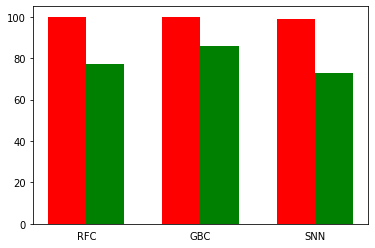

In [ ]:
Accuracy = [100, 100, 99]
acc_position = [1, 4, 7]
f1_score = [77, 86, 73]
f1_position = [2, 5, 8]
label = ['RFC', 'GBC', 'SNN']
label_position = [1.5, 4.5, 7.5]

plt.bar(acc_position, Accuracy, color = 'r', width=1)
plt.bar(f1_position, f1_score, color = 'g', width=1)
plt.xticks(label_position, label, fontsize=10, rotation=0)
plt.tick_params(
    axis='x',
    bottom=False)
plt.show()

# 적색은 정확도, 녹색은 F1_macro 평균 점수